# Singular Value Decomposition (SVD)

##### 2.a: merge IPSP datasets for multiple flow conditions and compute the SVD; the left singular vectors form the sequence of reduced states

In [1]:
import torch as pt
from torch import flatten
from flowtorch.analysis import SVD
import random
import bisect
import matplotlib.pyplot as plt
import matplotlib as mpl
from os.path import join
import numpy as np
random.seed(10)
plt.rcParams["figure.dpi"] = 180

output_path = "../output/SVD"
data_path = "../data"

Refer to the installation instructions at https://github.com/FlowModelingControl/flowtorch
If you are not using the TecplotDataloader, ignore this warning.


#### Prepare the data for SVD

In [2]:
# load data and extract keys
cp_084_data = pt.load(join(data_path, "cp_084_500snaps.pt"))
keys = list(cp_084_data.keys())

In [3]:
# sample two random keys for test data except the outer ones
test_keys = random.sample(keys[1:-1], 2)
print("The test keys are:       ", test_keys)

# assemble test data
X_test = pt.concat((cp_084_data[test_keys[0]].flatten(0, 1), cp_084_data[test_keys[1]].flatten(0, 1)), dim=1)
print("Shape of test_data is:   ", X_test.shape, "\n")

# extract the train keys and shuffle them
train_keys = [key for key in keys if key not in test_keys]
random.shuffle(train_keys)
print("The train keys are:      ", train_keys)

# assemble train data
X_train = cp_084_data[train_keys[0]].flatten(0, 1)
for i in range(1, len(train_keys)):
    X_train = pt.concat((X_train, cp_084_data[train_keys[i]].flatten(0, 1)), dim=1)
print("Shape of train_data is:  ", X_train.shape, "\n")

The test keys are:        ['ma0.84_alpha5.00', 'ma0.84_alpha3.00']
Shape of test_data is:    torch.Size([32768, 1000]) 

The train keys are:       ['ma0.84_alpha3.50', 'ma0.84_alpha1.50', 'ma0.84_alpha4.00', 'ma0.84_alpha6.00', 'ma0.84_alpha4.50']
Shape of train_data is:   torch.Size([32768, 2500]) 



#### Apply SVD on training data and save the left singular vectors

In [4]:
rank = 2500

# perform SVD on the data matrix where the temporal mean is subtracted from each column
svd = SVD(X_train - X_train.mean(dim=1).unsqueeze(-1), rank=rank)
print(svd, "\n")

# extract the left singular vectors, the right singular vectors and the singular values
U = svd.U
s = svd.s
V_t = svd.V
print("Shape of U is:           ", U.shape)
print("Shape of s is:           ", s.shape)
print("Shape of V is:           ", V_t.shape, "\n")

pt.save(U, join(output_path, "U.pt"))

SVD of a 32768x2500 data matrix
Selected/optimal rank: 2500/325
data type: torch.float32 (4b)
truncated SVD size: 336.3514Mb 

Shape of U is:            torch.Size([32768, 2500])
Shape of s is:            torch.Size([2500])
Shape of V is:            torch.Size([2500, 2500]) 



#### Plot Singular Value contributions

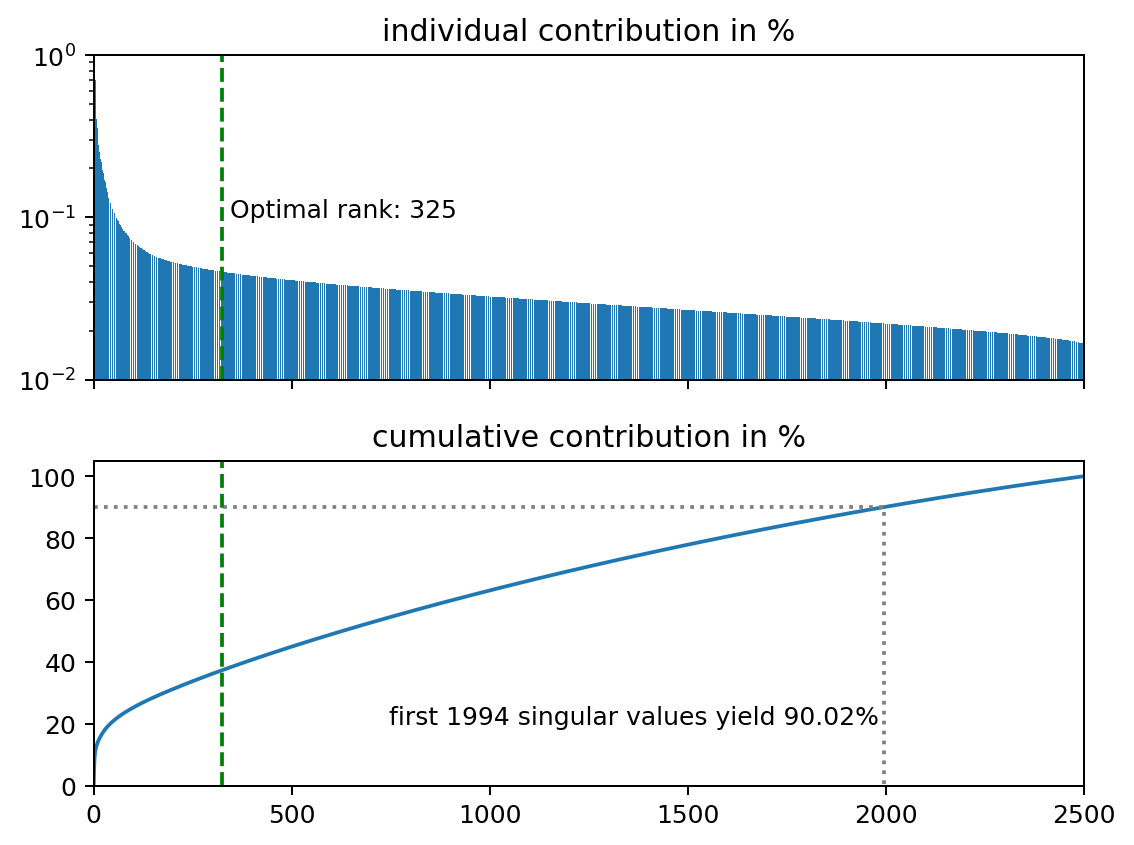

In [24]:
s_sum = s.sum().item()
# relative contribution
s_rel = [s_i / s_sum * 100 for s_i in s]
# cumulative contribution
s_cum = [s[:n].sum().item() / s_sum * 100 for n in range(s.shape[0])]
# find out how many singular values we need to reach at least 90 percent
i_90 = bisect.bisect_right(s_cum, 90)

fig1, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(range(rank), s_rel, align="edge")
ax1.axvline(svd.opt_rank, color="green", linestyle="--")
ax1.text(svd.opt_rank + 20, 1e-1, "Optimal rank: {}".format(svd.opt_rank))
ax1.set_title("individual contribution in %")
ax1.set_yscale("log")
ax1.set_ylim(1e-2, 1)

# fig2, ax2 = plt.subplots(figsize=(6, 2.5))
ax2.plot(range(s.shape[0]), s_cum)
ax2.set_xlim(0, rank)
ax2.set_ylim(0, 105)
ax2.set_title("cumulative contribution in %")
ax2.plot([0, i_90, i_90], [s_cum[i_90], s_cum[i_90], 0], ls="dotted", color="grey")
ax2.axvline(svd.opt_rank, color="green", linestyle="--")
ax2.text(i_90 - 1250, 20, "first {:d} singular values yield {:1.2f}%".format(i_90, s_cum[i_90]))


fig1.tight_layout()
fig1.savefig(join(output_path, "individ_and_cumulat_contribution.png"))

#### Plot Singular Value contributions to variance reconstruction

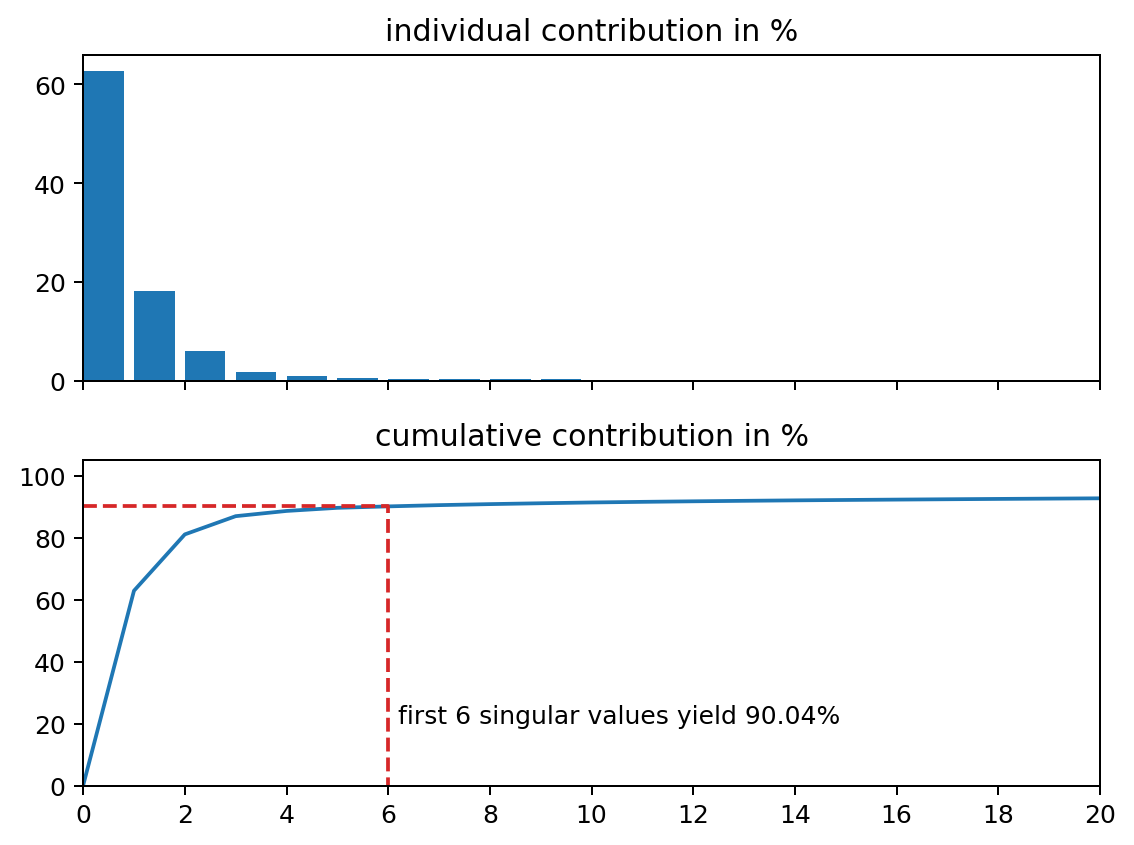

In [26]:
s_sum = (s**2).sum().item()
# relative contribution
s_rel = [s_i**2 / s_sum * 100 for s_i in s]
# cumulative contribution
s_cum = [(s[:n]**2).sum().item() / s_sum * 100 for n in range(s.shape[0])]
# find out how many singular values we need to reach at least 90 percent
i_90 = bisect.bisect_right(s_cum, 90)

x_lim = 20

fig1, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.bar(range(x_lim), s_rel[:x_lim], align="edge")
ax1.set_title("individual contribution in %")
ax2.plot(range(s.shape[0]), s_cum)
ax2.set_xlim(0, x_lim)
ax2.set_ylim(0, 105)
ax2.set_title("cumulative contribution in %")
ax2.plot([0, i_90, i_90], [s_cum[i_90], s_cum[i_90], 0], ls="--", color="C3")
ax2.text(i_90 + 0.2, 20, "first {:d} singular values yield {:1.2f}%".format(i_90, s_cum[i_90]))
ax2.set_xticks(range(0, x_lim + 1, 2))
fig1.tight_layout()
fig1.savefig(join(output_path, "variance_reconstruction.png"))